
- The os module has a perfect method to list files in a directory.
- Pandas json normalize could work here but is not necessary to convert the JSON data to a dataframe.
- You may need a nested for-loop to access each sale!
- We've put a lot of time into creating the structure of this repository, and it's a good example for future projects.  In the file functions_variables.py, there is an example function that you can import and use.  If you have any variables, functions or classes that you want to make, they can be put in the functions_variables.py file and imported into a notebook.  Note that only .py files can be imported into a notebook. If you want to import everything from a .py file, you can use the following:
```python
from functions_variables import *
```
If you just import functions_variables, then each object from the file will need to be prepended with "functions_variables"\
Using this .py file will keep your notebooks very organized and make it easier to reuse code between notebooks.

In [146]:
# (this is not an exhaustive list of libraries)
import pandas as pd
import numpy as np
import os
import json
from sklearn.model_selection import train_test_split
from pprint import pprint
from functions_variables import encode_tags
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Disable all warnings
warnings.filterwarnings('ignore')

In [147]:
'''
path = '../data/raw_json_files/AK_Juneau_0.json'
with open(path, 'r') as file:
    file1 = json.load(file)
pprint(file1)
'''
# This code is not needed
# load one file first to see what type of data you're dealing with and what attributes it has

"\npath = '../data/raw_json_files/AK_Juneau_0.json'\nwith open(path, 'r') as file:\n    file1 = json.load(file)\npprint(file1)\n"

At this point, ensure that you have all sales in a dataframe.
- Is each cell one value, or do some cells have lists?
- Maybe the "tags" will help create some features.
- What are the data types of each column?
- Some sales may not actually include the sale price.  These rows should be dropped.
- Some sales don't include the property type.
- There are a lot of None values.  Should these be dropped or replaced with something?

In [148]:
# Combine all json files

import glob

json_directory = '../data/raw_json_files'

json_file_paths = glob.glob(os.path.join(json_directory, '*.json'))
data = pd.DataFrame()

for path in json_file_paths:
    with open(path, 'r') as file:
        jsonfile = json.load(file)
    newdata = pd.json_normalize(jsonfile['data']['results'])
    data = pd.concat([newdata, data])

In [149]:
data.columns

Index(['last_update_date', 'tags', 'permalink', 'status', 'list_date',
       'open_houses', 'branding', 'list_price', 'property_id', 'photos',
       'community', 'virtual_tours', 'listing_id', 'price_reduced_amount',
       'matterport', 'primary_photo.href', 'source.plan_id', 'source.agents',
       'source.spec_id', 'source.type', 'description.year_built',
       'description.baths_3qtr', 'description.sold_date',
       'description.sold_price', 'description.baths_full', 'description.name',
       'description.baths_half', 'description.lot_sqft', 'description.sqft',
       'description.baths', 'description.sub_type', 'description.baths_1qtr',
       'description.garage', 'description.stories', 'description.beds',
       'description.type', 'lead_attributes.show_contact_an_agent',
       'flags.is_new_construction', 'flags.is_for_rent',
       'flags.is_subdivision', 'flags.is_contingent', 'flags.is_price_reduced',
       'flags.is_pending', 'flags.is_foreclosure', 'flags.is_plan',


In [150]:
# load and concatenate data here
# drop or replace values as necessary

In [151]:
def selectcolumns(new_column_names, selected_columns, data): # adds selected columns into new dataframe
    dataframe = pd.DataFrame()
    for i in range(len(selected_columns)):
        dataframe[f'{new_column_names[i]}'] = data[f'{selected_columns[i]}']
    return dataframe

selected_columns = ['description.year_built', 'description.sqft', 'description.baths', 'description.stories',
                    'description.beds', 'description.garage', 'description.type', 'flags.is_foreclosure',
                    'location.address.city', 'tags', 'description.sold_price']

new_column_names = ['year_built', 'sqft', 'baths', 'stories', 'beds', 'garage', 'type', 'is_foreclosure',
                    'city', 'tags', 'price']

dataframe = selectcolumns(new_column_names, selected_columns, data)

In [152]:
dataframe

,year_built,sqft,baths,stories,beds,garage,type,is_foreclosure,city,tags,price
0,1993.0,1926.0,2.0,1.0,3.0,2.0,single_family,None,Indianapolis,"[central_air, community_golf, community_spa_or...",269000
1,2004.0,2298.0,3.0,2.0,3.0,2.0,single_family,None,Indianapolis,"[central_air, dining_room, fireplace, forced_a...",315000
2,2003.0,2376.0,2.0,2.0,3.0,2.0,single_family,None,Indianapolis,"[central_air, community_security_features, din...",385000
3,1986.0,936.0,2.0,2.0,2.0,1.0,condos,None,Indianapolis,"[central_air, community_spa_or_hot_tub, dining...",161500
4,2003.0,3240.0,3.0,2.0,4.0,2.0,single_family,None,Indianapolis,"[city_view, community_park, community_spa_or_h...",310000
...,...,...,...,...,...,...,...,...,...,...,...
37,1988.0,1488.0,3.0,2.0,3.0,2.0,single_family,None,Harrisburg,"[central_air, disability_features, forced_air,...",229995
38,1989.0,4733.0,4.0,4.0,4.0,2.0,single_family,None,Harrisburg,"[central_air, dining_room, disability_features...",703125
39,1995.0,2341.0,3.0,2.0,3.0,2.0,single_family,None,Harrisburg,"[central_air, dishwasher, fireplace, forced_ai...",465000
40,1900.0,2601.0,3.0,3.0,3.0,NaN,townhomes,None,Harrisburg,"[central_air, forced_air, view, water_view, ba...",230000


In [153]:
dataframe.to_csv('../data/raw_merged_df_data.csv')

In [154]:
dataframe.isnull().sum()

year_built         875
sqft               868
baths              211
stories           1931
beds               687
garage            3743
type                66
is_foreclosure    8149
city                37
tags               553
price             1475
dtype: int64

In [155]:
dataframe.describe()

,year_built,sqft,baths,stories,beds
count,7316.000000,7323.000000,7980.000000,6260.000000,7504.000000
mean,1968.916074,1933.848559,2.131203,1.567732,3.208289
std,35.096914,1339.039206,1.175940,0.730969,1.282732
min,1828.000000,120.000000,0.000000,1.000000,0.000000
25%,1950.000000,1258.000000,1.000000,1.000000,3.000000
50%,1975.000000,1635.000000,2.000000,1.000000,3.000000
75%,1997.000000,2264.000000,3.000000,2.000000,4.000000
max,2024.000000,32106.000000,9.000000,10.000000,12.000000


In [156]:
# removing nulls

dataframe = dataframe[(dataframe['price'] > 0) &
                      (dataframe['sqft'] > 0) &
                      (dataframe['year_built'] > 0) &
                      (dataframe['baths'] > 0) &
                      (dataframe['stories'] > 0) &
                      (dataframe['beds'] > 0) &
                      (dataframe['price'] > 0)]

In [157]:
dataframe

,year_built,sqft,baths,stories,beds,garage,type,is_foreclosure,city,tags,price
0,1993.0,1926.0,2.0,1.0,3.0,2.0,single_family,None,Indianapolis,"[central_air, community_golf, community_spa_or...",269000
1,2004.0,2298.0,3.0,2.0,3.0,2.0,single_family,None,Indianapolis,"[central_air, dining_room, fireplace, forced_a...",315000
2,2003.0,2376.0,2.0,2.0,3.0,2.0,single_family,None,Indianapolis,"[central_air, community_security_features, din...",385000
3,1986.0,936.0,2.0,2.0,2.0,1.0,condos,None,Indianapolis,"[central_air, community_spa_or_hot_tub, dining...",161500
4,2003.0,3240.0,3.0,2.0,4.0,2.0,single_family,None,Indianapolis,"[city_view, community_park, community_spa_or_h...",310000
...,...,...,...,...,...,...,...,...,...,...,...
37,1988.0,1488.0,3.0,2.0,3.0,2.0,single_family,None,Harrisburg,"[central_air, disability_features, forced_air,...",229995
38,1989.0,4733.0,4.0,4.0,4.0,2.0,single_family,None,Harrisburg,"[central_air, dining_room, disability_features...",703125
39,1995.0,2341.0,3.0,2.0,3.0,2.0,single_family,None,Harrisburg,"[central_air, dishwasher, fireplace, forced_ai...",465000
40,1900.0,2601.0,3.0,3.0,3.0,NaN,townhomes,None,Harrisburg,"[central_air, forced_air, view, water_view, ba...",230000


In [158]:
dataframe.isnull().sum()

year_built           0
sqft                 0
baths                0
stories              0
beds                 0
garage            1961
type                 0
is_foreclosure    4888
city                 5
tags                65
price                0
dtype: int64

In [159]:
dataframe['type'].value_counts()

single_family    3637
condos            563
townhomes         464
multi_family      146
mobile             68
apartment          20
condo              10
Name: type, dtype: int64

In [160]:
dataframe['stories'].value_counts()

1.0     2500
2.0     1995
3.0      365
4.0       25
6.0       16
10.0       6
8.0        1
Name: stories, dtype: int64

In [161]:
# changing all nulls to 0

dataframe['garage'].fillna(0, inplace=True)

In [162]:
# changing all nulls to False

dataframe['is_foreclosure'].fillna('False', inplace=True)

In [163]:
dataframe.isnull().sum()

year_built         0
sqft               0
baths              0
stories            0
beds               0
garage             0
type               0
is_foreclosure     0
city               5
tags              65
price              0
dtype: int64

In [164]:
# dropping last few nulls

dataframe.dropna(inplace=True)

In [165]:
dataframe.isnull().sum()

year_built        0
sqft              0
baths             0
stories           0
beds              0
garage            0
type              0
is_foreclosure    0
city              0
tags              0
price             0
dtype: int64

In [166]:
# Final removed Nulls Dataframe

dataframe.dtypes

year_built        float64
sqft              float64
baths             float64
stories           float64
beds              float64
garage            float64
type               object
is_foreclosure     object
city               object
tags               object
price              object
dtype: object

In [167]:
dataframe.describe()

,year_built,sqft,baths,stories,beds,garage
count,4838.000000,4838.000000,4838.000000,4838.000000,4838.000000,4838.000000
mean,1970.668458,1874.154196,2.326995,1.604795,3.170112,1.154609
std,34.089147,992.776225,1.021649,0.764951,1.078383,1.117118
min,1828.000000,416.000000,1.000000,1.000000,1.000000,0.000000
25%,1951.000000,1256.000000,2.000000,1.000000,3.000000,0.000000
50%,1975.000000,1634.000000,2.000000,1.000000,3.000000,1.000000
75%,1999.000000,2215.000000,3.000000,2.000000,4.000000,2.000000
max,2023.000000,11218.000000,9.000000,10.000000,12.000000,9.000000


In [168]:
# Changing year_built into decades

bins = list(range(1820, 2031, 10))
labels = [i for i in bins[:-1]]

dataframe['year_built'] = pd.cut(dataframe['year_built'], bins=bins, labels=labels)
dataframe['year_built'] = dataframe['year_built'].astype(int)


In [169]:
# changing price into ranges

bins = list(range(0, 13000000, 200000))
labels = [i for i in bins[:-1]]

dataframe['price'] = pd.cut(dataframe['price'], bins=bins, labels=labels)
dataframe['price'] = dataframe['price'].astype(int)


In [170]:
# changing sqft into ranges

bins = list(range(0, 13000, 500))
labels = [i for i in bins[:-1]]

dataframe['sqft'] = pd.cut(dataframe['sqft'], bins=bins, labels=labels)
dataframe['sqft'] = dataframe['sqft'].astype(int)


In [171]:
# After changing Year_built, Sqft, Price Changes

dataframe

,year_built,sqft,baths,stories,beds,garage,type,is_foreclosure,city,tags,price
0,1990,1500,2.0,1.0,3.0,2.0,single_family,False,Indianapolis,"[central_air, community_golf, community_spa_or...",200000
1,2000,2000,3.0,2.0,3.0,2.0,single_family,False,Indianapolis,"[central_air, dining_room, fireplace, forced_a...",200000
2,2000,2000,2.0,2.0,3.0,2.0,single_family,False,Indianapolis,"[central_air, community_security_features, din...",200000
3,1980,500,2.0,2.0,2.0,1.0,condos,False,Indianapolis,"[central_air, community_spa_or_hot_tub, dining...",0
4,2000,3000,3.0,2.0,4.0,2.0,single_family,False,Indianapolis,"[city_view, community_park, community_spa_or_h...",200000
...,...,...,...,...,...,...,...,...,...,...,...
37,1980,1000,3.0,2.0,3.0,2.0,single_family,False,Harrisburg,"[central_air, disability_features, forced_air,...",200000
38,1980,4500,4.0,4.0,4.0,2.0,single_family,False,Harrisburg,"[central_air, dining_room, disability_features...",600000
39,1990,2000,3.0,2.0,3.0,2.0,single_family,False,Harrisburg,"[central_air, dishwasher, fireplace, forced_ai...",400000
40,1890,2500,3.0,3.0,3.0,0.0,townhomes,False,Harrisburg,"[central_air, forced_air, view, water_view, ba...",200000


In [172]:
dataframe['house_id'] = range(1, len(dataframe) + 1)
dataframe

,year_built,sqft,baths,stories,beds,garage,type,is_foreclosure,city,tags,price,house_id
0,1990,1500,2.0,1.0,3.0,2.0,single_family,False,Indianapolis,"[central_air, community_golf, community_spa_or...",200000,1
1,2000,2000,3.0,2.0,3.0,2.0,single_family,False,Indianapolis,"[central_air, dining_room, fireplace, forced_a...",200000,2
2,2000,2000,2.0,2.0,3.0,2.0,single_family,False,Indianapolis,"[central_air, community_security_features, din...",200000,3
3,1980,500,2.0,2.0,2.0,1.0,condos,False,Indianapolis,"[central_air, community_spa_or_hot_tub, dining...",0,4
4,2000,3000,3.0,2.0,4.0,2.0,single_family,False,Indianapolis,"[city_view, community_park, community_spa_or_h...",200000,5
...,...,...,...,...,...,...,...,...,...,...,...,...
37,1980,1000,3.0,2.0,3.0,2.0,single_family,False,Harrisburg,"[central_air, disability_features, forced_air,...",200000,4834
38,1980,4500,4.0,4.0,4.0,2.0,single_family,False,Harrisburg,"[central_air, dining_room, disability_features...",600000,4835
39,1990,2000,3.0,2.0,3.0,2.0,single_family,False,Harrisburg,"[central_air, dishwasher, fireplace, forced_ai...",400000,4836
40,1890,2500,3.0,3.0,3.0,0.0,townhomes,False,Harrisburg,"[central_air, forced_air, view, water_view, ba...",200000,4837


In [173]:
# Extract tags into a separate DataFrame
tags_expanded = dataframe[['house_id', 'tags']].explode('tags')
#rename column
tags_expanded.rename(columns={'tags': 'tag'}, inplace=True)
#merge expanded tags dataframe back with the original dataframe

top_tags_name = tags_expanded['tag'].value_counts().head(20).index.to_list()

def remove_non_top_tags(row, top_tags_name):
    for i in top_tags_name:
        if i == row['tag']:
            return row

tags = tags_expanded.apply(remove_non_top_tags, args=(top_tags_name,), axis=1).dropna()
houseinfo_df = pd.merge(dataframe.drop(columns=['tags']), tags, on='house_id')
#adding some code here

In [174]:
houseinfo_df

,year_built,sqft,baths,stories,beds,garage,type,is_foreclosure,city,price,house_id,tag
0,1990,1500,2.0,1.0,3.0,2.0,single_family,False,Indianapolis,200000,1,central_air
1,1990,1500,2.0,1.0,3.0,2.0,single_family,False,Indianapolis,200000,1,dining_room
2,1990,1500,2.0,1.0,3.0,2.0,single_family,False,Indianapolis,200000,1,fireplace
3,1990,1500,2.0,1.0,3.0,2.0,single_family,False,Indianapolis,200000,1,forced_air
4,1990,1500,2.0,1.0,3.0,2.0,single_family,False,Indianapolis,200000,1,recreation_facilities
...,...,...,...,...,...,...,...,...,...,...,...,...
37604,1890,2500,3.0,3.0,3.0,0.0,townhomes,False,Harrisburg,200000,4837,two_or_more_stories
37605,1920,1000,1.0,2.0,3.0,0.0,townhomes,False,Harrisburg,0,4838,dishwasher
37606,1920,1000,1.0,2.0,3.0,0.0,townhomes,False,Harrisburg,0,4838,washer_dryer
37607,1920,1000,1.0,2.0,3.0,0.0,townhomes,False,Harrisburg,0,4838,basement


In [175]:
#checking for nulls
houseinfo_df.isnull().sum()

year_built        0
sqft              0
baths             0
stories           0
beds              0
garage            0
type              0
is_foreclosure    0
city              0
price             0
house_id          0
tag               0
dtype: int64

Consider the fact that with tags, there are a lot of categorical variables.
- How many columns would we have if we OHE tags, city and state?
- Perhaps we can get rid of tags that have a low frequency.

In [176]:
# OHE categorical variables here
# One-hot encode categorical columns: 'type', 'city', and 'tag'
# tags will have to be done manually changes

In [177]:
# One-hot encode the 'tag' column
one_hot_encoded_tags = pd.get_dummies(houseinfo_df['tag'])
#join OHE df with house id df
one_hot_encoded_df = pd.concat([houseinfo_df[['house_id']], one_hot_encoded_tags], axis=1)

# Group by house_id and sum the one-hot encoded columns
one_hot_encoded_df = one_hot_encoded_df.groupby('house_id').sum().reset_index() # -> to ensure we have everything aligned properly

# Merge the one-hot encoded tags back with the original DataFrame
# Drop the original 'tag' column and duplicates before merging
df_no_tags = houseinfo_df.drop(columns=['tag']).drop_duplicates(subset='house_id')
df_final = pd.merge(df_no_tags, one_hot_encoded_df, on='house_id')
df_final

,year_built,sqft,baths,stories,beds,garage,type,is_foreclosure,city,price,...,garage_1_or_more,garage_2_or_more,hardwood_floors,laundry_room,recreation_facilities,shopping,single_story,two_or_more_stories,view,washer_dryer
0,1990,1500,2.0,1.0,3.0,2.0,single_family,False,Indianapolis,200000,...,1,1,0,0,1,0,1,0,1,0
1,2000,2000,3.0,2.0,3.0,2.0,single_family,False,Indianapolis,200000,...,1,1,0,0,0,0,0,1,0,0
2,2000,2000,2.0,2.0,3.0,2.0,single_family,False,Indianapolis,200000,...,1,1,1,0,0,0,0,1,1,0
3,1980,500,2.0,2.0,2.0,1.0,condos,False,Indianapolis,0,...,1,0,0,0,1,1,0,1,1,0
4,2000,3000,3.0,2.0,4.0,2.0,single_family,False,Indianapolis,200000,...,1,1,0,0,1,1,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4833,1980,1000,3.0,2.0,3.0,2.0,single_family,False,Harrisburg,200000,...,1,1,0,0,0,0,0,1,0,0
4834,1980,4500,4.0,4.0,4.0,2.0,single_family,False,Harrisburg,600000,...,1,1,1,0,0,0,0,1,0,0
4835,1990,2000,3.0,2.0,3.0,2.0,single_family,False,Harrisburg,400000,...,1,1,0,0,0,0,0,1,0,1
4836,1890,2500,3.0,3.0,3.0,0.0,townhomes,False,Harrisburg,200000,...,0,0,0,0,0,0,0,1,1,0


In [178]:
#test and validate merge and OHE
houseinfo_df[houseinfo_df['house_id'] == 1]

,year_built,sqft,baths,stories,beds,garage,type,is_foreclosure,city,price,house_id,tag
0,1990,1500,2.0,1.0,3.0,2.0,single_family,False,Indianapolis,200000,1,central_air
1,1990,1500,2.0,1.0,3.0,2.0,single_family,False,Indianapolis,200000,1,dining_room
2,1990,1500,2.0,1.0,3.0,2.0,single_family,False,Indianapolis,200000,1,fireplace
3,1990,1500,2.0,1.0,3.0,2.0,single_family,False,Indianapolis,200000,1,forced_air
4,1990,1500,2.0,1.0,3.0,2.0,single_family,False,Indianapolis,200000,1,recreation_facilities
5,1990,1500,2.0,1.0,3.0,2.0,single_family,False,Indianapolis,200000,1,view
6,1990,1500,2.0,1.0,3.0,2.0,single_family,False,Indianapolis,200000,1,single_story
7,1990,1500,2.0,1.0,3.0,2.0,single_family,False,Indianapolis,200000,1,garage_1_or_more
8,1990,1500,2.0,1.0,3.0,2.0,single_family,False,Indianapolis,200000,1,garage_2_or_more


In [179]:
df_final.drop(columns='house_id', inplace=True)
df_final.iloc[0]

year_built                              1990
sqft                                    1500
baths                                    2.0
stories                                  1.0
beds                                     3.0
garage                                   2.0
type                           single_family
is_foreclosure                         False
city                            Indianapolis
price                                 200000
basement                                   0
central_air                                1
central_heat                               0
city_view                                  0
community_outdoor_space                    0
community_security_features                0
dining_room                                1
dishwasher                                 0
fireplace                                  1
forced_air                                 1
garage_1_or_more                           1
garage_2_or_more                           1
hardwood_f

- Sales will vary drastically between cities and states.  Is there a way to keep information about which city it is without OHE such as using central tendency?
- Could we label encode or ordinal encode?  Yes, but this may have undesirable effects, giving nominal data ordinal values.
- If you replace cities or states with numerical values, make sure that the data is split so that we don't leak data into the training selection. This is a great time to train test split. Compute on the training data, and join these values to the test data
- Drop columns that aren't needed.
- Don't keep the list price because it will be too close to the sale price.

In [180]:
# perform train test split here

#Define the features X and Y
X = df_final.drop(columns=['price'])
Y = df_final['price']

# Split 80/20
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

#Print
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"Y_train shape: {Y_train.shape}")
print(f"Y_test shape: {Y_test.shape}")


# do something with state and city
# drop any other not needed columns

X_train shape: (3870, 29)
X_test shape: (968, 29)
Y_train shape: (3870,)
Y_test shape: (968,)


**STRETCH**

- You're not limited to just using the data provided to you. Think/ do some research about other features that might be useful to predict housing prices. 
- Can you import and join this data? Make sure you do any necessary preprocessing and make sure it is joined correctly.
- Example suggestion: could mortgage interest rates in the year of the listing affect the price? 

In [181]:
# import, join and preprocess new data here

Remember all of the EDA that you've been learning about?  Now is a perfect time for it!
- Look at distributions of numerical variables to see the shape of the data and detect outliers.
- Scatterplots of a numerical variable and the target go a long way to show correlations.
- A heatmap will help detect highly correlated features, and we don't want these.
- Is there any overlap in any of the features? (redundant information, like number of this or that room...)

In [182]:
# perform EDA here

df_final.describe()

,year_built,sqft,baths,stories,beds,garage,price,basement,central_air,central_heat,...,garage_1_or_more,garage_2_or_more,hardwood_floors,laundry_room,recreation_facilities,shopping,single_story,two_or_more_stories,view,washer_dryer
count,4838.000000,4838.000000,4838.000000,4838.000000,4838.000000,4838.000000,4.838000e+03,4838.000000,4838.000000,4838.000000,...,4838.000000,4838.000000,4838.000000,4838.000000,4838.000000,4838.000000,4838.000000,4838.000000,4838.000000,4838.000000
mean,1964.774700,1638.176933,2.326995,1.604795,3.170112,1.154609,3.380736e+05,0.446259,0.619057,0.199669,...,0.656470,0.446052,0.365647,0.282141,0.264986,0.287929,0.505374,0.494626,0.223646,0.314593
std,34.806843,1005.451208,1.021649,0.764951,1.078383,1.117118,5.766325e+05,0.497155,0.485669,0.399793,...,0.474936,0.497132,0.481661,0.450088,0.441371,0.452845,0.500023,0.500023,0.416731,0.464401
min,1820.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1950.000000,1000.000000,2.000000,1.000000,3.000000,0.000000,2.000000e+05,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1970.000000,1500.000000,2.000000,1.000000,3.000000,1.000000,2.000000e+05,0.000000,1.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,1990.000000,2000.000000,3.000000,2.000000,4.000000,2.000000,4.000000e+05,1.000000,1.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000
max,2020.000000,11000.000000,9.000000,10.000000,12.000000,9.000000,1.240000e+07,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [183]:
df_final.shape

(4838, 30)

In [184]:
numerical_data = df_final.select_dtypes(include=['float64', 'int64']).iloc[:, :7]
categorical_data = df_final.select_dtypes(include=['object'])
tags_data = df_final.select_dtypes(include=['float64', 'int64']).iloc[:, 7:]

In [185]:
df_final

,year_built,sqft,baths,stories,beds,garage,type,is_foreclosure,city,price,...,garage_1_or_more,garage_2_or_more,hardwood_floors,laundry_room,recreation_facilities,shopping,single_story,two_or_more_stories,view,washer_dryer
0,1990,1500,2.0,1.0,3.0,2.0,single_family,False,Indianapolis,200000,...,1,1,0,0,1,0,1,0,1,0
1,2000,2000,3.0,2.0,3.0,2.0,single_family,False,Indianapolis,200000,...,1,1,0,0,0,0,0,1,0,0
2,2000,2000,2.0,2.0,3.0,2.0,single_family,False,Indianapolis,200000,...,1,1,1,0,0,0,0,1,1,0
3,1980,500,2.0,2.0,2.0,1.0,condos,False,Indianapolis,0,...,1,0,0,0,1,1,0,1,1,0
4,2000,3000,3.0,2.0,4.0,2.0,single_family,False,Indianapolis,200000,...,1,1,0,0,1,1,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4833,1980,1000,3.0,2.0,3.0,2.0,single_family,False,Harrisburg,200000,...,1,1,0,0,0,0,0,1,0,0
4834,1980,4500,4.0,4.0,4.0,2.0,single_family,False,Harrisburg,600000,...,1,1,1,0,0,0,0,1,0,0
4835,1990,2000,3.0,2.0,3.0,2.0,single_family,False,Harrisburg,400000,...,1,1,0,0,0,0,0,1,0,1
4836,1890,2500,3.0,3.0,3.0,0.0,townhomes,False,Harrisburg,200000,...,0,0,0,0,0,0,0,1,1,0


### Exploratory Data Analysis (EDA)

Exploratory Data Analysis (EDA) is a crucial step in the data analysis process, and visualizations play a fundamental role in understanding the dataset, uncovering patterns, and identifying relationships between variables. We (Kiran and I) chose 6 from an exhaustive list to show the correlation of the selected features and their respective impact to the price/cost of the house. The purpose and importance of each visualization is shown below along with a summary of the results.


#### 1. **Correlation Heatmap**
**Purpose**: To identify the strength and direction of relationships between numerical features.
**Reason**: 
- Helps in understanding which features are strongly correlated with the target variable (`price`).
- Identifies multicollinearity among features, which can inform feature selection and engineering.
- Guides further analysis by highlighting key variables that significantly influence the target variable.

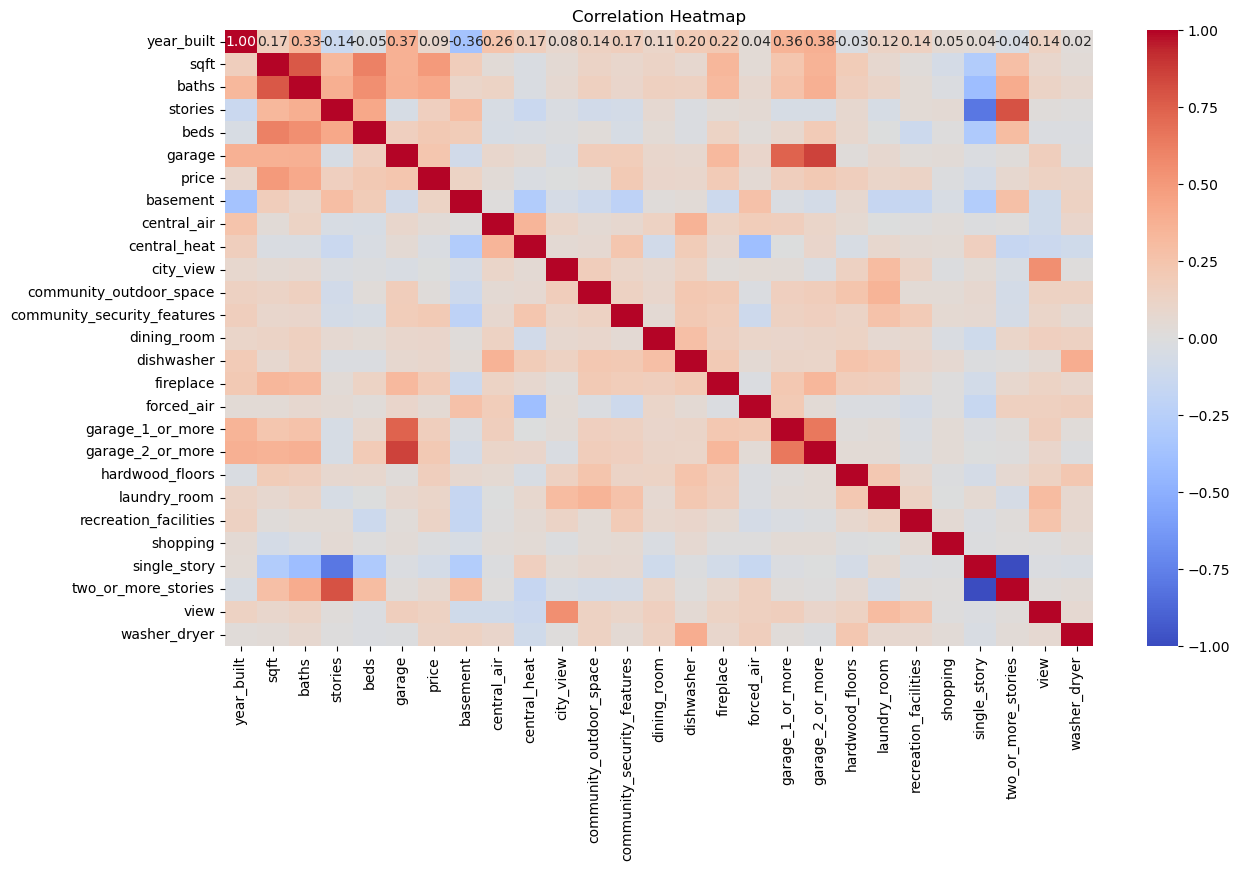

In [186]:
# Calculate the correlation matrix
corr = df_final.corr()

# Plot pf heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

##### Observation Summary/Findings
The heatmap provides a visual summary of the correlation coefficients between different features and the price. Features like `sqft`, `baths`, `garage`, and `year_built` show moderate positive correlations with price, indicating they are important factors influencing house prices. Other features show weaker correlations, highlighting areas where further investigation or feature engineering might be needed to understand their impact on price. The heatmap helps in identifying both strong and weak relationships, guiding further analysis and model development.

#### 2. **Pairplot**
**Purpose**: To visualize pairwise relationships and distributions of numerical features.\
**Reason**: 
- Provides a comprehensive view of the interactions between features.
- Helps in spotting trends, clusters, and outliers.
- Facilitates the detection of potential non-linear relationships that might require transformation or advanced modeling techniques.
- Offers insights into the overall distribution of each feature, aiding in understanding their spread and central tendencies.

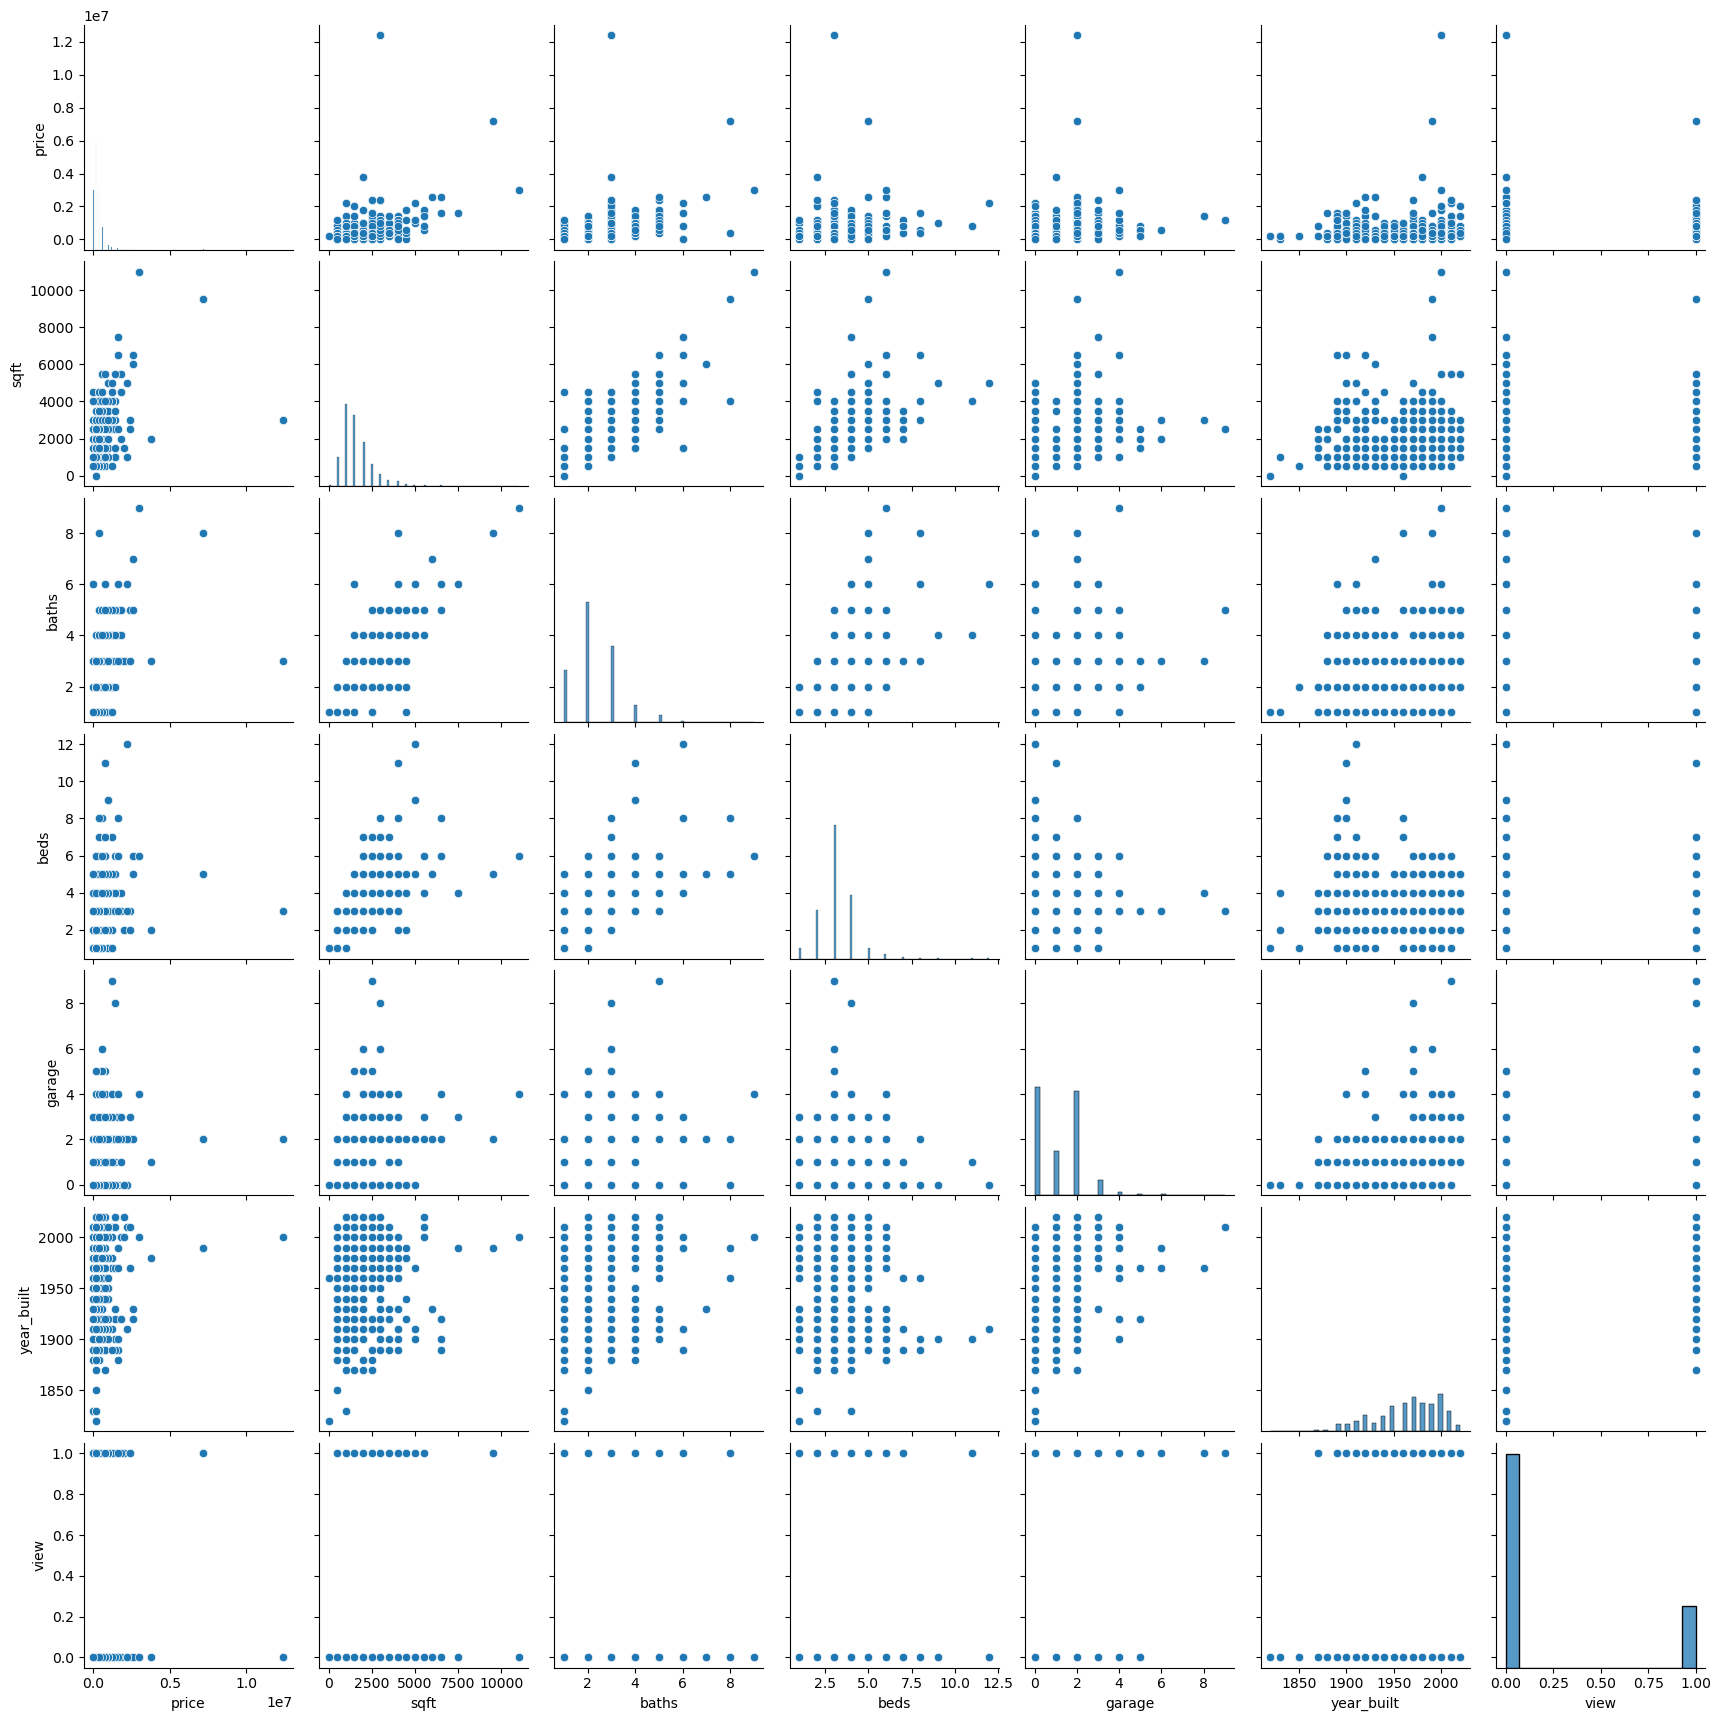

In [187]:
#Pairplot for selected features
selected_features = ['price', 'sqft', 'baths', 'beds', 'garage', 'year_built', 'view']
sns.pairplot(df_final[selected_features])
plt.show()

##### Observation Summary/Findings
The pairplot reveals important relationships between the selected features and `price`. Key insights include the positive correlations of `price` with `sqft`, `baths`, `beds`, `garage`, and `year_built`, indicating that these features are important determinants of house prices. The distribution and scatterplots help in understanding the spread and variability within these relationships, identifying potential trends, and highlighting outliers. This comprehensive view aids in further analysis and informs feature selection for predictive modeling.

#### 3. **Price Distribution Plot**
**Purpose**: To examine the distribution of the target variable (`price`).
**Reason**: 
- Reveals the central tendency, variability, and skewness of house prices.
- Identifies potential outliers and unusual data points that might require special handling.
- Provides a clear picture of the overall price range and helps in setting realistic expectations for predictive modeling.

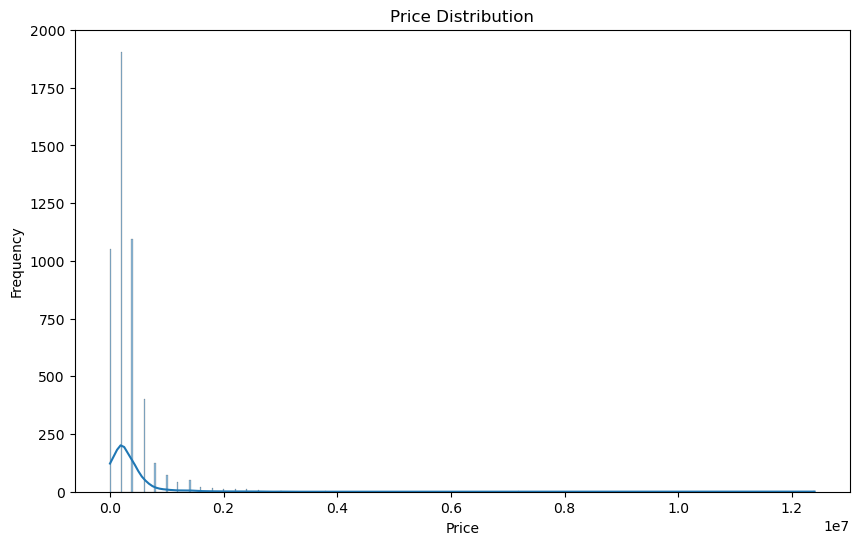

In [188]:
# Price column Distribution
plt.figure(figsize=(10, 6))
sns.histplot(df_final['price'], kde=True)
plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

#### Observation Summary/Findings

The price distribution plot shows the frequency distribution of house prices in the dataset. Here are the key observations from the plot:

1. **Right-Skewed Distribution**:
   - The distribution is highly right-skewed, with a long tail extending towards the higher price values.
   - Most of the houses are clustered at the lower end of the price range, indicating that lower-priced houses are much more common in the dataset.

2. **Peak Frequency**:
   - There is a sharp peak at the very low end of the price range, suggesting a high concentration of houses priced at the lower end.
   - The highest frequency is observed for houses priced close to the lower limit, indicating a large number of affordable houses.

3. **Outliers**:
   - The long tail extending to the right indicates the presence of outliers, which are houses with very high prices.
   - These outliers are significantly fewer in number compared to the lower-priced houses but have a substantial impact on the overall price distribution.

4. **Kernel Density Estimate (KDE)**:
   - The KDE line provides a smooth estimate of the distribution, further highlighting the right-skewness and the concentration of prices at the lower end.

5. **Price Range**:
   - The x-axis shows that house prices range from close to zero up to over 10 million (1e7).
   - The majority of the data points fall within the first quarter of the price range, with a sharp decline in frequency as prices increase.

### Summary

The price distribution plot reveals that the dataset is dominated by lower-priced houses, with a significant right-skewness indicating the presence of a few very high-priced properties. This distribution suggests that while most houses are affordable, there are some luxury properties that significantly raise the upper limit of the price range. 

#### 4. **Box Plots**

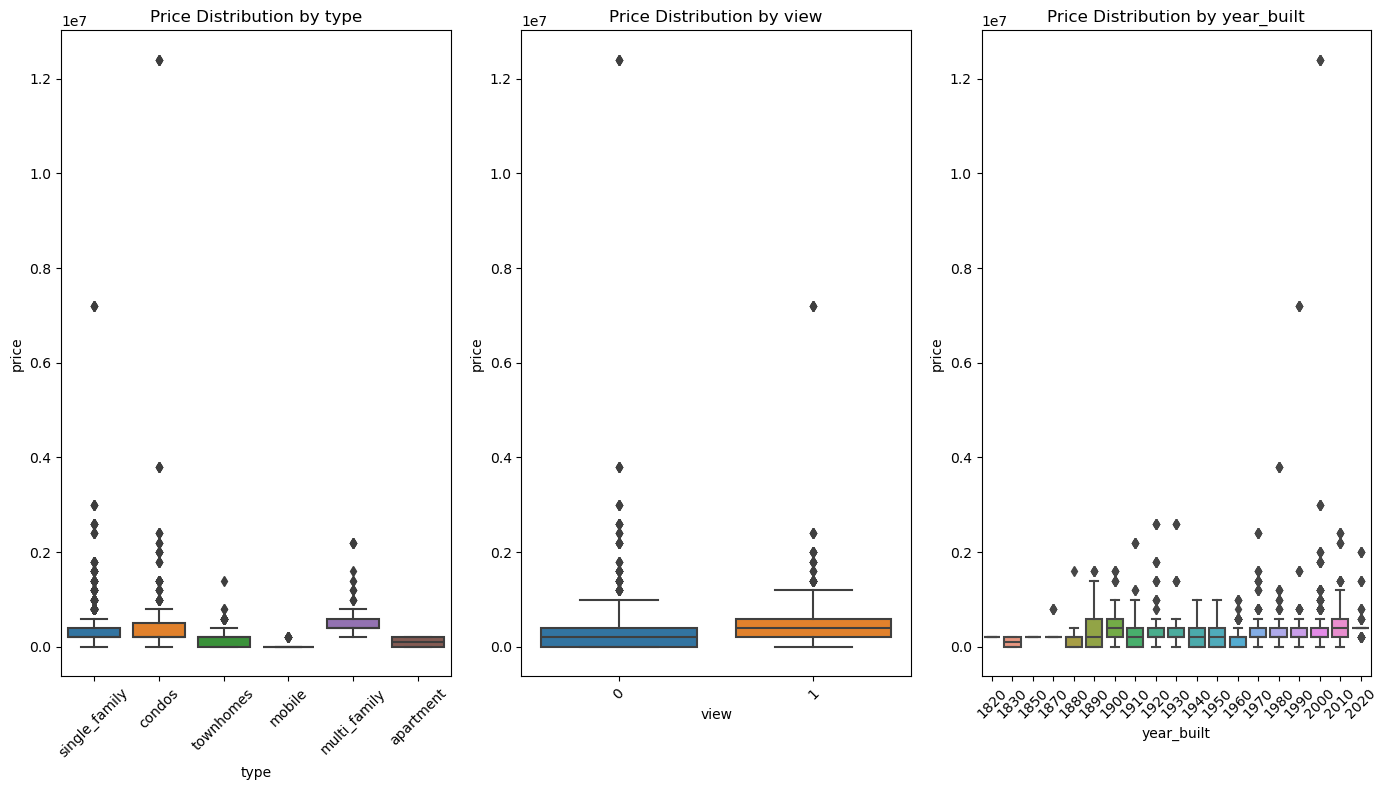

In [189]:
# Plot boxplots for categorical features vs price
categorical_features = ['type', 'view', 'year_built']

plt.figure(figsize=(14, 8))
for i, feature in enumerate(categorical_features, 1):
    plt.subplot(1, len(categorical_features), i)
    sns.boxplot(x=df_final[feature], y=df_final['price'])
    plt.title(f'Price Distribution by {feature}')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

#### 5. **Bar Graphs for Categorical Features**
**Purpose**: To compare the average price across different categories of categorical features.
**Reason**: 
- Highlights how categorical variables like `type`, `year_built`, and `isforeclosure` influence house prices.
- Assists in identifying significant categorical variables that impact the target variable.
- Helps in understanding the distribution of prices across different groups, which is essential for segment analysis and targeted strategies.

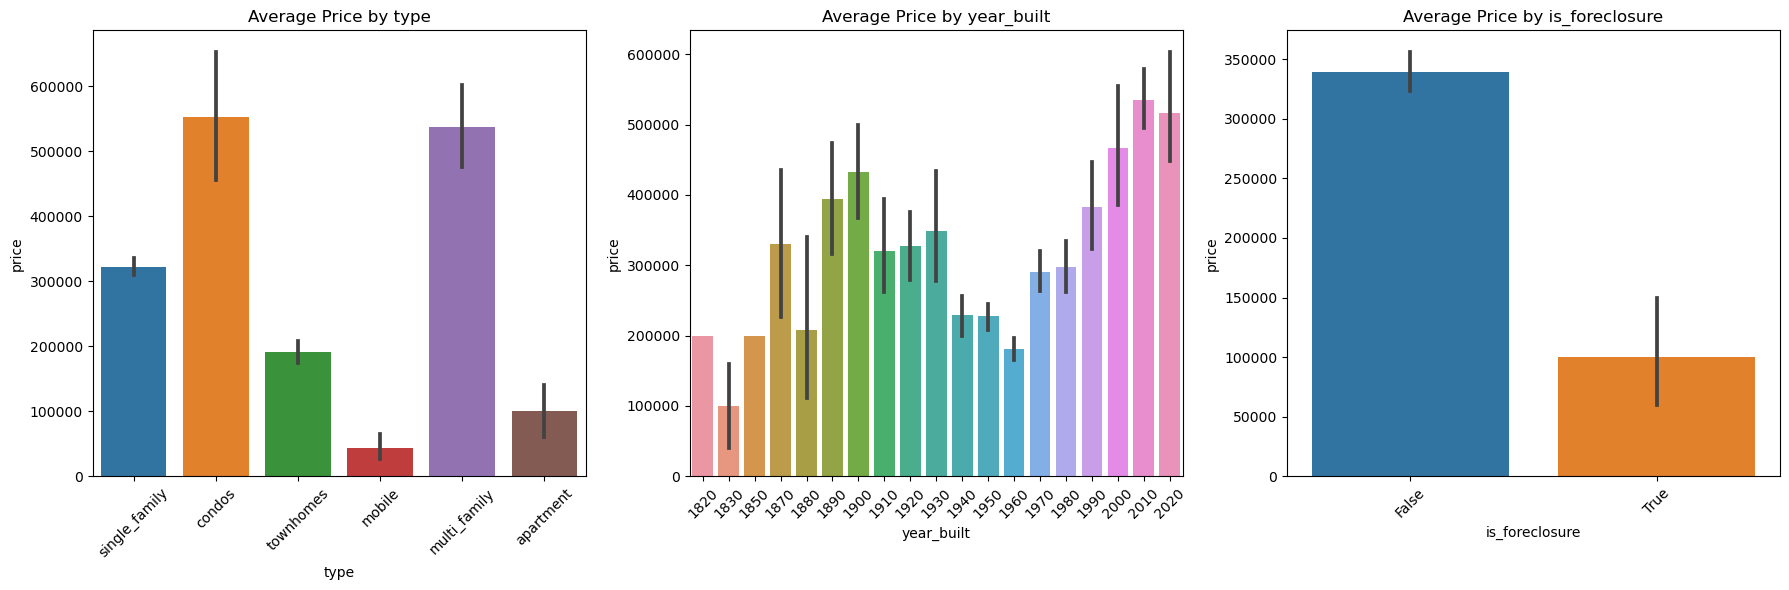

In [190]:
# List of categorical features
#adding comment
categorical_features = ['type', 'year_built', 'is_foreclosure']

# Plot bar graphs for each categorical feature
plt.figure(figsize=(18, 6))
for i, feature in enumerate(categorical_features, 1):
    plt.subplot(1, len(categorical_features), i)
    sns.barplot(x=feature, y='price', data=df_final)
    plt.title(f'Average Price by {feature}')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

#### Observation Summary/Findings
The bar graphs provide valuable insights into how categorical features like property type, year built, and foreclosure status impact house prices:

- **Property Type**: Single-family homes are generally the most expensive, followed by townhomes and condos.
- **Year Built**: Newer homes tend to have higher prices, with prices decreasing for older homes.
- **Foreclosure Status**: Foreclosed properties are sold at lower prices compared to non-foreclosed homes.


#### 6. **Bar Graphs for Numerical Features**
**Purpose**: To show the average price across different bins of numerical features.
**Reason**: 
- Demonstrates how changes in numerical features like `sqft`, `baths`, `beds`, `garage`, and `year_built` affect house prices.
- Facilitates the understanding of non-linear relationships by visualizing average prices across feature bins.
- Helps in identifying thresholds and breaking points where the impact of numerical features on price changes significantly.

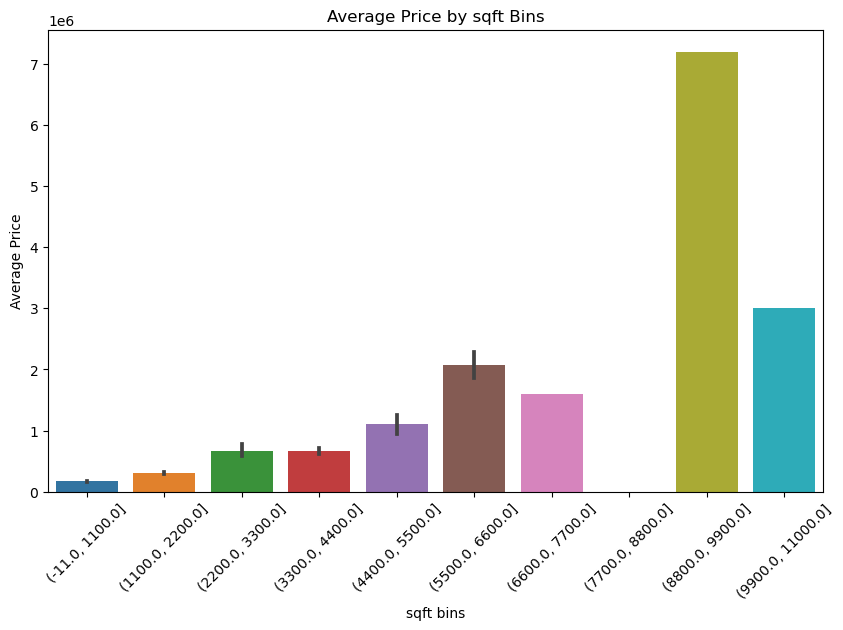

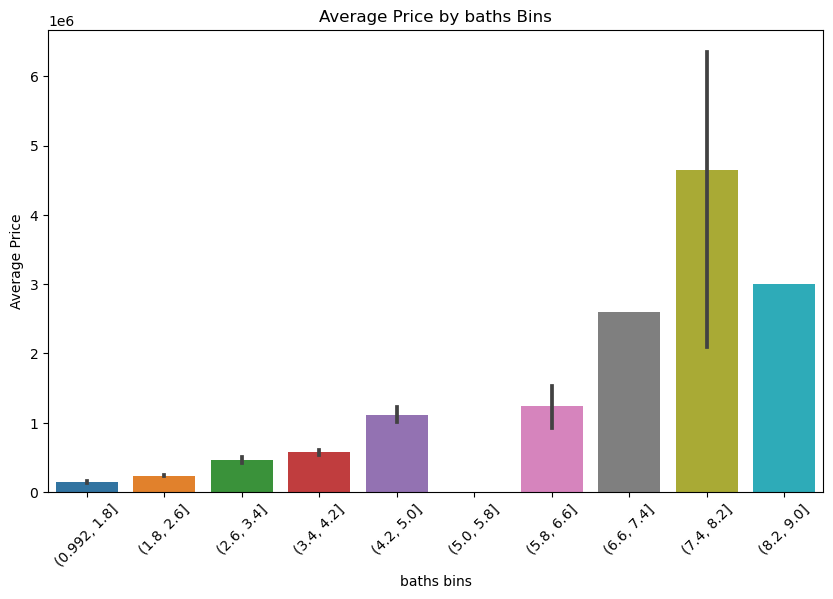

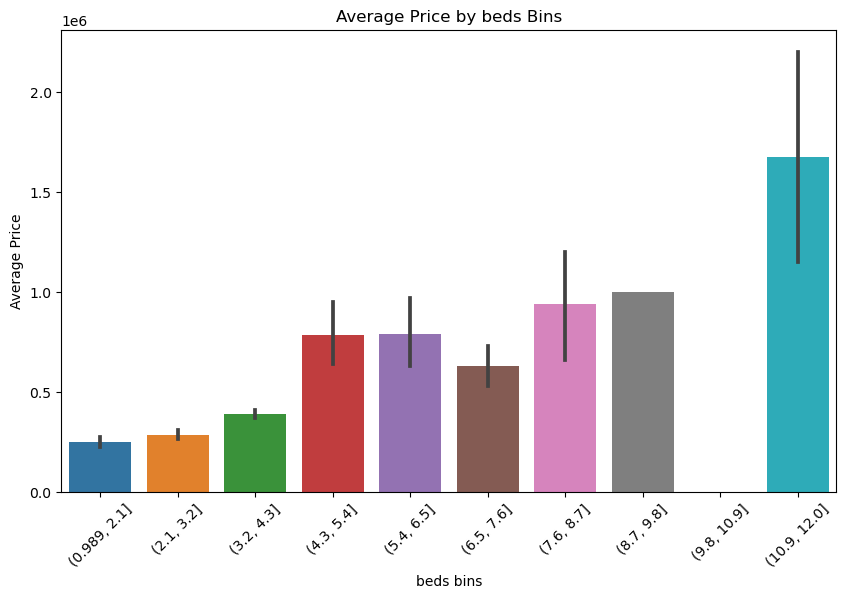

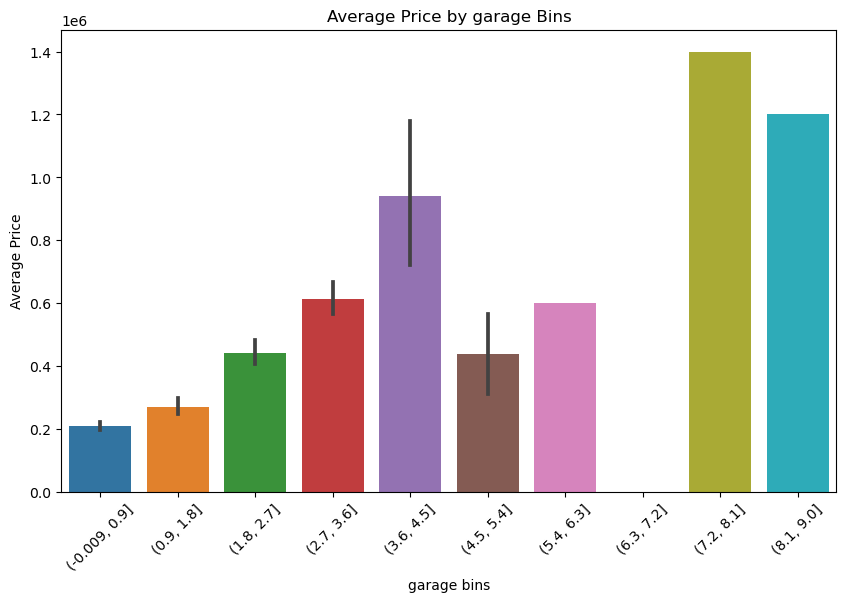

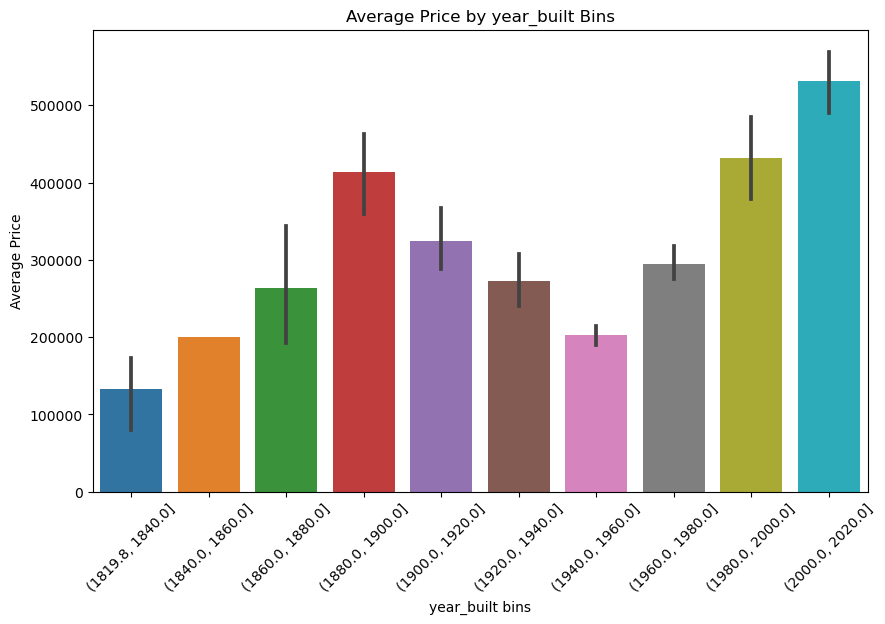

In [191]:
# List of numerical features
numerical_features = ['sqft', 'baths', 'beds', 'garage', 'year_built']

# Function to create bins and plot bar graphs


def plot_numerical_feature_binned(df, feature, bins=10):
    df_final[f'{feature}_bin'] = pd.cut(df_final[feature], bins=bins)
    plt.figure(figsize=(10, 6))
    sns.barplot(x=f'{feature}_bin', y='price', data=df_final)
    plt.title(f'Average Price by {feature} Bins')
    plt.xticks(rotation=45)
    plt.xlabel(f'{feature} bins')
    plt.ylabel('Average Price')
    plt.show()


# Plot bar graphs for each numerical feature
for feature in numerical_features:
    plot_numerical_feature_binned(df_final, feature, bins=10)

Now is a great time to scale the data and save it once it's preprocessed.
- You can save it in your data folder, but you may want to make a new `processed/` subfolder to keep it organized

In [192]:
X_train.to_csv('../data/training/X_train.csv', index=False)

# Export X_test to CSV
X_test.to_csv('../data/testing/X_test.csv', index=False)

# Export Y_train to CSV
Y_train.to_csv('../data/training/Y_train.csv', index=False)

# Export Y_test to CSV
Y_test.to_csv('../data/testing/Y_test.csv', index=False)

# Export processed dataframe - df_final to CSV
df_final.to_csv('../data/processed/df_final_processed.csv', index=False)